In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.special import eval_laguerre
import itertools
import copy
from image_matrix_helper import compute_master_list, imshow_list, rgb_map, color_to_rgb, list_to_matrix
import random
import time

nb_start = time.time()

## Exploring System Types

In this notebook, we again simulate the system presented in `general_grid_assembly.ipynb`, but do so for three different parameter regimes that have qualitatively distinct thermal behaviors. 

We will use much of the code from that section so we copy it here without additional explanation

### Numerical representations of analytical work

#### Equations of Large $N$ approximation 

In the large $N$ limit, the order parameters for the system can be approximated as 

\begin{equation}
\langle k \rangle =   \sum_{j=1}^r \frac{n_j }{\bar{z} \gamma_j +1} \left(\bar{z} \gamma_j +  \frac{\displaystyle L_{n_j-1} \left( \bar{\phi}_{j}\right)}{\displaystyle  L_{n_j} \left( \bar{\phi}_{j} \right)}\right) \qquad \langle m \rangle  =   \sum_{j=1}^r \frac{n_j \delta_j}{\delta_j-1} \frac{\displaystyle L_{n_j-1} \left( \bar{\phi}_{j}\right)}{\displaystyle  L_{n_j} \left( \bar{\phi}_{j} \right)},
\end{equation}
where $\bar{z}$ and $\bar{x}$ are defined as 
\begin{equation}
\bar{z} = \sum_{j=1}^{R} \frac{n_j}{\bar{z} \gamma_j +1} \left(1- \frac{\displaystyle L_{n_j-1} \left( \bar{\phi}_{j}\right)}{\displaystyle  L_{n_j} \left( \bar{\phi}_{j} \right)}\right), \qquad \bar{x} = \sum_{j=1}^{R} n_j\left(1- \frac{\displaystyle L_{n_j-1} \left( \bar{\phi}_{j}\right)}{\displaystyle  L_{n_j} \left( \bar{\phi}_{j} \right)}\right)
\end{equation}
with
\begin{equation}
\bar{\phi}_{j}\equiv \frac{\bar{x}}{1-\delta_j}\left(1+ \frac{1}{\bar{z} \gamma_j}\right).
\label{eq:phi_def}
\end{equation}
and $L_n(x)$ the $n$th Laguerre polynomial. 

For these simulations we will take $$\gamma_j = (\beta E_V)^{3/2} e^{-\beta E_j}, \qquad \delta_j = e^{\beta \Delta_j}$$ where $E_V$ is a volumetric Boltzmann factor associated with free particles (e.g., for a point-particle $E_V \equiv h^2/2\pi mV^{2/3}$), and $E_j$ is the binding energy for particles to the grid. We also take where $\Delta_j$ is the binding energy advantage for particles binding to their correct locations in the grid. 

#### Parameter function definitions

In [2]:
# helper function definitions
gamma_func = lambda E0, Ev, T: 4*np.sqrt(2)*np.exp(E0/T)*(Ev/T)**(3/2)
delta_func = lambda Del, T: np.exp(Del/T)
phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta) 

#### Equilibrium equations

In [3]:
def constr_func(X, T, E0s, Dels, Evs, Ns):
    
    """
    Equations constraint equations that determine zbar and xbar
    """
    
    x = X[0]
    z = X[1]
    
    F = np.ones(2)
    
    R = len(Ns)
    gammas_ = gamma_func(E0s,Evs, T)
    deltas_ = delta_func(Dels, T)
    phis_ = phi_func(x, z, gammas_, deltas_)
    
    F[0] = z- np.sum([Ns[j]/(z*gammas_[j]+1)*(1-eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j])) for j in range(R)])
    F[1] = x- np.sum([Ns[j]*(1-eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j]) ) for j in range(R)])
                     
    return F
    
def m_avg(T, E0s, Dels, Evs, Ns):
    
    """
    Function that computes m_avg
    """    
    
    x, z =  fsolve(constr_func, x0 = (50,500), args = (T, E0s, Dels, Evs, Ns))
    
    R = len(Ns)
    gammas_ = gamma_func(E0s,Evs, T)
    deltas_ = delta_func(Dels, T)
    phis_ = phi_func(x, z, gammas_, deltas_)
    
    return np.sum([Ns[j]*deltas_[j]/(deltas_[j]-1)*eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j]) for j in range(R)] )
    
def k_avg( T, E0s, Dels, Evs, Ns):
    
    """
    Function that computes k_avg
    """       
    
    x, z = fsolve(constr_func, x0 = (50,500), args = (T, E0s, Dels, Evs, Ns))

    R = len(Ns)
    gammas_ = gamma_func(E0s,Evs, T)
    deltas_ = delta_func(Dels, T)
    phis_ = phi_func(x, z, gammas_, deltas_)    
    
    return np.sum([Ns[j]/(z*gammas_[j]+1)*(z*gammas_[j] + eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j])) for j in range(R)])

#### Important temperatures

For characterizing the differences between search and combinatorics-limited systems there are three relevant temperatures:

$$T_{\text{bind}}:\qquad 1=  \sum_{j=1}^R n_j \gamma_{j}(T)^{-1}\delta_j(T)^{-1}$$

$$ T_{\text{derang}}: \qquad 1=  \sum_{j=1}^R n_j \delta_j(T)^{-1}$$

$$ T_{\text{crit}}: \qquad 1=  \sum_{j=1}^R n_j \delta_j(T)^{-1}(1+ \gamma_{j}(T)^{-1})$$

Generally, we say that a system is combinatorics-limited when 
\begin{equation}
\text{Combinatorics-limited System:} \qquad T_{\text{comb}} \simeq T_{\text{crit}}
\end{equation}
and a system is search-limited when
\begin{equation}
\text{Search-limited System:} \qquad T_{\text{search}} \simeq T_{\text{crit}}.
\end{equation}

In [4]:
# Implicit equations defining temperature 
def binding_constr(T, E0s, Dels, Evs, Ns):
    F =  1-np.sum(Ns*delta_func(Dels, T)**(-1)*gamma_func(E0s, Evs, T)**(-1))
    return F

def derang_constr(T,Dels, Ns):
    F =  1-np.sum(Ns*np.exp(-Dels/T))
    return F

def crit_constr(T, E0s, Dels, Evs, Ns):
    F =  1-np.sum(Ns*delta_func(Dels, T)**(-1)*(1+gamma_func(E0s, Evs, T)**(-1)))
    return F 

# Computing temperatures from implicit equations
kBT_bind = lambda E0s, Dels, Evs, Ns: fsolve(binding_constr, x0 = 100.5, args = (E0s, Dels, Evs, Ns))[0]
kBT_derang = lambda Dels, Ns: fsolve(derang_constr, x0 = 100.5, args = (Dels, Ns))[0]
kBT_crit = lambda E0s, Dels, Evs, Ns: fsolve(crit_constr, x0 = 100.5, args = (E0s, Dels, Evs, Ns))[0]


### Metropolis Hastings simulation code 

#### Microstate transitions

In [5]:
## dissociation operator
def trans_dissoc(free_objs, bound_objs):
        
        # indices of non-empty
        indxs = [i for i, x in enumerate(bound_objs) if x != "-"]
        
        # random choice for bound object
        random_indx = random.choice(indxs)

        ## new state vector 
        free_objs_new = copy.deepcopy(free_objs)
        bound_objs_new = copy.deepcopy(bound_objs)

        # putting empty slot
        bound_objs_new[random_indx] = '-'
        # appending previously bound object to free objects
        free_objs_new.append(bound_objs[random_indx])

        return free_objs_new, bound_objs_new


## association operator
def trans_assoc(free_objs, bound_objs):
    
        # random element to associate
        elem = random.choice(free_objs)

        # indices of empty spaces
        indxs = [i for i, x in enumerate(bound_objs) if x == "-"]  

        # random choice for empty space
        random_indx = random.choice(indxs)

        ## new state vector 
        free_objs_new = copy.deepcopy(free_objs)
        bound_objs_new = copy.deepcopy(bound_objs)    

        ## state
        free_objs_new.remove(elem)
        bound_objs_new[random_indx] = elem      

        return free_objs_new, bound_objs_new

## permutation operator
def trans_perm(free_objs, bound_objs):
    
    Ncomp = len(bound_objs)
    i1 = int(random.choice(range(Ncomp)))
    i2 = int(random.choice(range(Ncomp)))

    ## new omega vector 
    bound_objs_new = copy.deepcopy(bound_objs)
    bound_objs_new[i2] = bound_objs[i1]
    bound_objs_new[i1] = bound_objs[i2]
    
    return free_objs, bound_objs_new

#### Logarithm of Botlzmann factor

The logarithm of the Botlzmann factor for a microstate (i.e., the temperature normalized negative energy of the microstate) is defined as 

\begin{equation}
\beta E(\boldsymbol{k}, \boldsymbol{m}) = \sum_{i=1}^R(m_i \ln \delta_i + k_i \ln \gamma_i).
\label{eq:sim_en}
\end{equation}

In [6]:
def log_boltz(free_objs, bound_objs, mstr_vec, deltas, gammas, name_key):
    
    elem_set = list(set(mstr_vec))
    count_dict = dict()
    for elem in elem_set:
        count_dict[elem] = bound_objs.count(elem)

    bind_log_factor = 0
    for elem in elem_set:
        key = name_key[elem]
        bind_log_factor += count_dict[elem]*np.log(gammas[key])
        
        
    corr_log_factor = 0
    for j in range(len(bound_objs)):
        if bound_objs[j] == mstr_vec[j]:
            elem = bound_objs[j]
            key = name_key[elem]
            corr_log_factor+=np.log(deltas[key])        
    
    return bind_log_factor+corr_log_factor    

#### Function to count the number of correctly bound particles

In [7]:
def m_calc(bound_objs, mstr_vec):
    
    num = 0
    for k in range(len(mstr_vec)):
        if mstr_vec[k] == bound_objs[k]:
            num += 1
    return num

#### Metropolis Hastings algorithm

In [8]:
### Metropolis Monte Carlo Algorithm 

## loads uniform random sampling 
runif = np.random.rand

def met_assembly_grid(Niter, free_objs, bound_objs, mstr_vec, deltas, gammas, name_key):
    '''
    #################################################################
    # function to sample using Metropolis 
    #  
    # n_iter:  number of iterations
    # initial_state: initial state for the start position for our chain
    # gamma: energy cost for incorrect component
    # temp: temperature 
    ##################################################################
    '''
    
    # Initialize state values
    free_objs_vals = [0]*(Niter+1)
    bound_objs_vals = [0]*(Niter+1)
    
    # Set initial values
    free_objs_vals[0] = free_objs[:]
    bound_objs_vals[0] = bound_objs[:]
        
    # Initialize acceptance counts
    # We can use this to tune our number of steps
    accepted = 0
    
    # debugging code
    debug_assoc, debug_dissoc, debug_perm = 0, 0, 0
    
    for i in range(Niter):
    
        # get current monomer and dimer states
        current_free_objs = copy.deepcopy(free_objs_vals[i])
        current_bound_objs = copy.deepcopy(bound_objs_vals[i])
        
        N_free = len(current_free_objs)
        N_bound = len(current_bound_objs)-len(current_free_objs)
        
        u_trans = runif()
        
        if u_trans < 1/3: #first type of transition; monomer association 
            
            if N_free < 1:
                
                log_alpha = np.log(1e-15) 
            
            else:
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_assoc(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, deltas, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, deltas, gammas, name_key)

                # weight
                num = N_free*N_free
                den = N_bound+1

                # Log-acceptance rate
                log_alpha = log_final-log_init+np.log(num/den) 
            
        elif 1/3 <= u_trans < 2/3: #second type of transition; bound monomer dissociation
            
            if N_bound <1:
                
                log_alpha = np.log(1e-15) 
                
            else: 
                
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_dissoc(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, deltas, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, deltas, gammas, name_key)

                # weight
                num = N_bound 
                den = (N_free+1)*(N_free+1)   

                # Log-acceptance rate
                log_alpha = log_final-log_init+np.log(num/den) 
            
        elif 2/3 <= u_trans: #third type of transition; switching bounded elements
            
            if N_bound <2:
                
                log_alpha = np.log(1e-15) 
            
            else:
                
                # proposed new monomer and dimer states
                new_free_objs, new_bound_objs = trans_perm(current_free_objs, current_bound_objs)

                # transition elements
                log_init = log_boltz(current_free_objs, current_bound_objs, mstr_vec, deltas, gammas, name_key)
                log_final = log_boltz(new_free_objs, new_bound_objs, mstr_vec, deltas, gammas, name_key)

                # Log-acceptance rate
                log_alpha = log_final-log_init
            
        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < log_alpha:
            # Accept
            free_objs_vals[i+1] = new_free_objs
            bound_objs_vals[i+1] = new_bound_objs
            
            #log_current_prob = log_proposed_prob
            accepted += 1
        else:
            # Stay put
            free_objs_vals[i+1] = free_objs_vals[i]
            bound_objs_vals[i+1] = bound_objs_vals[i]

    # return our samples and the number of accepted steps
    return free_objs_vals, bound_objs_vals, accepted

#### Computing microstate averages from simiulations

In [9]:
def avg_k(bound_objs_vals, Nmc):
    
    """
    Microstate average of number of bound objects
    We only consider microstates near the end of theh chain to ensure
    that the system has equilibrated
    """
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] = len(bound_objs_vals[Nmc-length+k]) - bound_objs_vals[Nmc-length+k].count('-')
    
    return(np.mean(ls))

# average number of correctly bound objects
def avg_m(bound_objs_vals, mstr_vec, Nmc):
    
    """
    Microstate average of number of correctly bound objects
    We only consider microstates near the end of theh chain to ensure
    that the system has equilibrated
    """ 
    
    length = int(Nmc/50)
    
    ls = [0]*length
    ls = np.array(ls)
    for k in range(length):
        ls[k] =  np.sum([1 for j in range(len(mstr_vec)) if bound_objs_vals[Nmc-length+k][j]==mstr_vec[j]])
    
    return(np.mean(ls))

#### Image grid for completely correct configuration

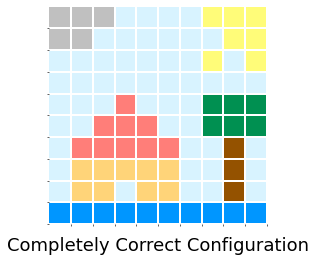

In [10]:
# defining master_list
master_list =compute_master_list()
# testing plot
imshow_list(master_list, title = 'Completely Correct Configuration');
# defining Nelems
Nelems = np.zeros(8)
key_list = list(rgb_map.keys())[:-1]
name_key_ = dict()
for j in range(len(key_list)):
    name_key_[key_list[j]] = j
    Nelems[j] = master_list.count(key_list[j])

In [11]:
# displaying copy-number counts of the various elements
Nelems

array([ 9.,  9., 10.,  5.,  7.,  6.,  3., 51.])

### Search-limited, Indeterminate, and Combinatorics-limited system simulations

In [12]:
# setting parameter dictionary
param_dict = {'Search Limited': {'Del_bar':7.7501 , 
                                 'sigma_D':2.0, 
                                 'E0_bar':3.0, 
                                 'sigma_E':1.0},
              'Combinatorics Limited':{'Del_bar': 4.75, 
                                 'sigma_D': 2.0, 
                                 'E0_bar': 16.0, 
                                 'sigma_E':3.0}, 
              'Indeterminate': {'Del_bar': 6.75, 
                                 'sigma_D': 2.0, 
                                 'E0_bar': 10.75, 
                                 'sigma_E': 3.0}, }

In [13]:
## Generate lf for each temperature from .03 to 2.0 in npoints steps

t0_start = time.time()

# number of steps for MC algortihm
Nmc = 30000
    
random.seed(0)

# initial monomer and dimer states; 
# system in microstate of all correct dimers
free_objs_0 = []
bound_objs_0 = random.sample(master_list, len(master_list))
mstr_vec = copy.deepcopy(master_list)

# temperature limits
Tmin = .05
Tmax = 3.0

npoints = 15 #number of temperature values
navg = 5 # number of times we run simulation at each temperature; 50 in paper
temp_vals = np.linspace(Tmin, Tmax, npoints).tolist()

sim_k_vals_dict = {'Search Limited': [0]*npoints,
              'Combinatorics Limited':[0]*npoints, 
              'Indeterminate':[0]*npoints }

sim_m_vals_dict = {'Search Limited': [0]*npoints,
              'Combinatorics Limited':[0]*npoints, 
              'Indeterminate':[0]*npoints }

# list of dimer values 
sim_k_vals = [0]*npoints
# list of correct dimer values
sim_m_vals = [0]*npoints

for type_ in list(sim_k_vals_dict.keys()):

    t0 = time.time()      
    
    # getting parameter values
    dict_vals = param_dict[type_]
    
    # drawing energy values
    np.random.seed(24)
    R=8
    Del_bar, sigma_D = dict_vals['Del_bar'], dict_vals['sigma_D']
    Dels = np.random.randn(R)*sigma_D+Del_bar
    E0_bar, sigma_E = dict_vals['E0_bar'], dict_vals['sigma_E']
    E0s = np.random.randn(R)*sigma_E+E0_bar 
    Evs = np.ones(R)*0.001
    
    for k in range(npoints):

        fin_k_vals = [0]*navg
        fin_m_vals = [0]*navg
        fin_accepted = [0]*navg

        for j in range(navg): 

            # make copy of initial monomer and dimer states 
            free_objs_copy = copy.deepcopy(free_objs_0)
            bound_objs_copy = copy.deepcopy(bound_objs_0)

            # defining helper functions
            gammas_ = gamma_func(E0s, Evs, temp_vals[k])
            deltas_ = delta_func(Dels, temp_vals[k])  

            # metroplois generator
            free_list, bound_list, accepted = met_assembly_grid(Nmc, 
                                                                free_objs_copy,
                                                                bound_objs_copy,
                                                                mstr_vec,
                                                                deltas_,
                                                                gammas_,
                                                                name_key_) 




            # averaging final states to compute observables
            fin_k_vals[j] = avg_k(bound_list, Nmc)
            fin_m_vals[j] = avg_m(bound_list, mstr_vec, Nmc)

        # averaging over computed equilibrium averages
        sim_k_vals_dict[type_][k] = np.mean(np.array(fin_k_vals))
        sim_m_vals_dict[type_][k] = np.mean(np.array(fin_m_vals))

        t_prelim = time.time()
        print("Temperature Run:",str(k+1),"; Current Time:", round(t_prelim-t0,2),"secs")


    t1 = time.time()
    print(f"\nTotal Simulation Run Time for {type_}: {round(t1-t0,2)} secs")
    print("----------\n") 
    
t1 = time.time()    
print("------------------------------\n------------------------------")   
print(f"Total Simulation Run Time for all: {round(t1-t0_start,2)} secs")    

Temperature Run: 1 ; Current Time: 49.3 secs
Temperature Run: 2 ; Current Time: 105.02 secs
Temperature Run: 3 ; Current Time: 166.1 secs
Temperature Run: 4 ; Current Time: 225.39 secs
Temperature Run: 5 ; Current Time: 294.01 secs
Temperature Run: 6 ; Current Time: 360.05 secs
Temperature Run: 7 ; Current Time: 419.58 secs
Temperature Run: 8 ; Current Time: 472.65 secs
Temperature Run: 9 ; Current Time: 520.46 secs
Temperature Run: 10 ; Current Time: 564.49 secs
Temperature Run: 11 ; Current Time: 606.29 secs
Temperature Run: 12 ; Current Time: 644.35 secs
Temperature Run: 13 ; Current Time: 681.3 secs
Temperature Run: 14 ; Current Time: 717.6 secs
Temperature Run: 15 ; Current Time: 751.73 secs

Total Simulation Run Time for Search Limited: 751.73 secs
----------

Temperature Run: 1 ; Current Time: 44.95 secs
Temperature Run: 2 ; Current Time: 91.21 secs
Temperature Run: 3 ; Current Time: 137.59 secs
Temperature Run: 4 ; Current Time: 179.81 secs
Temperature Run: 5 ; Current Time: 22

<ipython-input-2-a582446d2d66>:4: RuntimeWarning: divide by zero encountered in true_divide
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
<ipython-input-2-a582446d2d66>:4: RuntimeWarning: invalid value encountered in multiply
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
<ipython-input-2-a582446d2d66>:4: RuntimeWarning: overflow encountered in true_divide
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
/Users/mobolajiwilliams/opt/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Search Limited


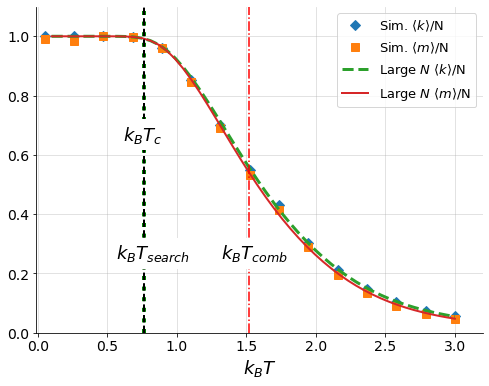

<ipython-input-2-a582446d2d66>:4: RuntimeWarning: divide by zero encountered in true_divide
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
<ipython-input-2-a582446d2d66>:4: RuntimeWarning: invalid value encountered in multiply
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
/Users/mobolajiwilliams/opt/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-3-08aba1dbaf99>:17: RuntimeWarning: invalid value encountered in double_scalars
  F[0] = z- np.sum([Ns[j]/(z*gammas_[j]+1)*(1-eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j])) for j in range(R)])
<ipython-input-3-08aba1dbaf99>:18: RuntimeWarning: invalid value encountered in double_scalars
  F[1] = x- np.sum([Ns[j]*(1-eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j]) ) for j in

Combinatorics Limited


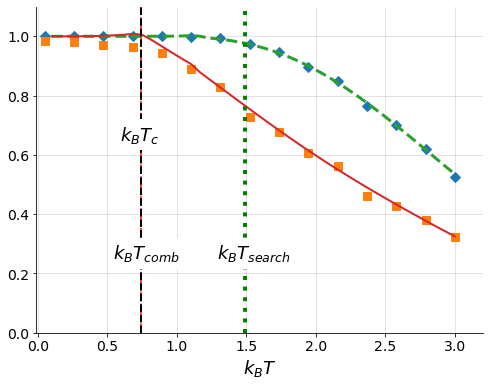

<ipython-input-2-a582446d2d66>:4: RuntimeWarning: divide by zero encountered in true_divide
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
<ipython-input-2-a582446d2d66>:4: RuntimeWarning: invalid value encountered in multiply
  phi_func = lambda x, z, gamma, delta: x*(1+ 1/(z*gamma))/(1-delta)
/Users/mobolajiwilliams/opt/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-3-08aba1dbaf99>:17: RuntimeWarning: invalid value encountered in double_scalars
  F[0] = z- np.sum([Ns[j]/(z*gammas_[j]+1)*(1-eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j])) for j in range(R)])
<ipython-input-3-08aba1dbaf99>:18: RuntimeWarning: invalid value encountered in double_scalars
  F[1] = x- np.sum([Ns[j]*(1-eval_laguerre(Ns[j]-1, phis_[j])/eval_laguerre(Ns[j], phis_[j]) ) for j in

Indeterminate


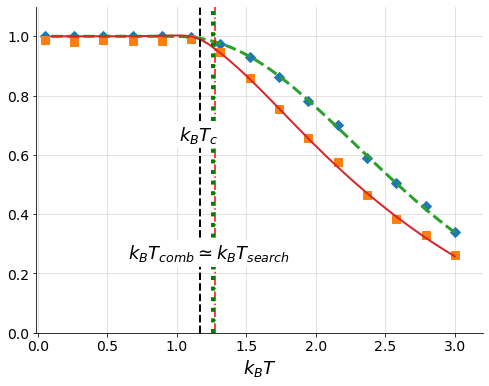

In [14]:
# temperature limits
Tmin = .05
Tmax = 3.0

npoints = 15 #number of temperature values
navg = 1 # number of times we run simulation at each temperature; 50 in paper
temp_vals = np.linspace(Tmin, Tmax, npoints).tolist() # simulation temperature values
Tvals = np.linspace(0.1, 3.0, 50) # analytic temperature values

u = 0
for type_ in list(sim_k_vals_dict.keys()):
    
    plt.figure(figsize = (8,6))
    ax = plt.subplot(111)    

    t0 = time.time()      
    
    # getting parameter values
    dict_vals = param_dict[type_]
    
    # drawing energy values
    np.random.seed(24)
    R=8
    Del_bar, sigma_D = dict_vals['Del_bar'], dict_vals['sigma_D']
    Dels = np.random.randn(R)*sigma_D+Del_bar
    E0_bar, sigma_E = dict_vals['E0_bar'], dict_vals['sigma_E']
    E0s = np.random.randn(R)*sigma_E+E0_bar 
    Evs = np.ones(R)*0.001

    # simulation results
    plt.plot(temp_vals,np.array(sim_k_vals_dict[type_])/np.sum(Nelems), 
            label = r'Sim. $\langle k \rangle$/N',
            markersize = 7.5,
           marker = 'D',
           linestyle = '')
    plt.plot(temp_vals,np.array(sim_m_vals_dict[type_])/np.sum(Nelems), 
            label = r'Sim. $\langle m \rangle$/N',
            markersize = 7.5,
           marker = 's',
           linestyle = '')

    # large N analytical results
    k_avg_approx_vals = [k_avg(T, E0s, Dels, Evs, Nelems)/np.sum(Nelems) for T in Tvals]
    m_avg_approx_vals = [m_avg(T, E0s, Dels, Evs, Nelems)/np.sum(Nelems) for T in Tvals]
    plt.plot(Tvals, k_avg_approx_vals, label = r'Large $N$ $\langle k \rangle$/N', linestyle= '--', linewidth = 3.0)
    plt.plot(Tvals, m_avg_approx_vals, label = r'Large $N$ $\langle m \rangle$/N', linewidth = 2.0 )

    ax.axvline(x = kBT_derang(Dels, Nelems), color = 'r', linestyle = '-.')
    ax.axvline(x = kBT_bind( E0s, Dels, Evs, Nelems), color = 'g', linestyle = ':', linewidth = 4)
    ax.axvline(x = kBT_crit( E0s, Dels, Evs, Nelems), color = 'k', linestyle = 'dashed', linewidth = 2)

    if u == 0:
        plt.legend(loc = 'best', fontsize = 13)
        
    # plot formatting
    ax.set_xlabel(r'$k_B T$', fontsize = 18)
    plt.xlim([-0.01,3.2])
    plt.ylim([0,1.1])
    plt.grid(alpha = 0.45)


    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # increase label size
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

    if u<2: 
        ax.text(kBT_derang(Dels, Nelems)-.2, 0.25, r'$k_BT_{comb}$', color='black', fontsize = 18,
                bbox=dict(facecolor='white', edgecolor='none', pad=5.0))
        ax.text(kBT_bind(E0s, Dels, Evs, Nelems)-.2, 0.25, r'$k_BT_{search}$', color='black', fontsize = 18,
                bbox=dict(facecolor='white', edgecolor='none', pad=5.0))
        ax.text(kBT_crit(E0s, Dels,Evs, Nelems)-.15, 0.65, r'$k_BT_{c}$', color='black', fontsize = 18,
                bbox=dict(facecolor='white', edgecolor='none', pad=5.0))        

    else:
        ax.text(kBT_derang(Dels, Nelems)-.625, 0.25, r'$k_BT_{comb} \simeq k_BT_{search}$', color='black', fontsize = 18,
                bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
        ax.text(kBT_crit(E0s, Dels,Evs, Nelems)-.15, 0.65, r'$k_BT_{c}$', color='black', fontsize = 18,
                bbox=dict(facecolor='white', edgecolor='none', pad=3.0))       
    
    
    u+=1
    
#     type_name = type_.replace(' ', '_').lower()
#     plt.savefig(f'general_grid_assembly_sim_anl_{type_name}.png', bbox_inches='tight', format = 'png')
    
    print(type_)
    plt.show()

In [15]:
print('Total Notebook Runtime: %.3f mins' % ((time.time()-nb_start)/60))

Total Notebook Runtime: 37.247 mins
